In [ ]:
!git clone https://github.com/SiddharthMaverick/PCB_Defect_Classification_Deep_Learning.git

fatal: destination path 'pcb_defects_classification' already exists and is not an empty directory.


In [ ]:
%cd pcb_defects_classification

/content/pcb_defects_classification


In [ ]:
import os
from tools import config

if not os.path.exists(config.DEFECTS_PATH):
    !python "tools/extracted_defetcs.py"

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import cv2

In [ ]:
datagenAug = ImageDataGenerator(
    rotation_range=90,
	zoom_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	validation_split=0.2
)

In [ ]:
trainGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="training")

testGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="validation")

Found 8012 images belonging to 6 classes.
Found 2001 images belonging to 6 classes.


In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False,  input_tensor=Input(shape=(224, 224, 3)))

for layer in vgg_model.layers[:-1]:
    layer.trainable = False

head = vgg_model.output
flatten = Flatten()(head)
fc = Dense(512, activation='relu')(flatten)
output = Dense(len(trainGen.class_indices), activation="softmax")(fc)

model = Model(inputs=vgg_model.input, outputs=output)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#checkpoint = ModelCheckpoint(os.path.sep.join([config.OUTPUT_PATH, "vgg.h5"]), monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
checkpoint = ModelCheckpoint(os.path.sep.join([config.OUTPUT_PATH, "vgg.keras"]), monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

early = EarlyStopping(monitor='accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model.fit(
    trainGen, steps_per_epoch=trainGen.samples // 32,
	validation_data=testGen, validation_steps=testGen.samples // 32,
	epochs=15, callbacks=[checkpoint, early])

model.save(os.path.sep.join([config.OUTPUT_PATH, "vgg.model"]), save_format='h5')

Streaming output truncated to the last 5000 lines.
 10/250 [>.............................] - ETA: 1:57 - loss: 0.1545 - accuracy: 0.9594
Epoch 6: accuracy did not improve from 1.00000
 11/250 [>.............................] - ETA: 1:54 - loss: 0.1406 - accuracy: 0.9631
Epoch 6: accuracy did not improve from 1.00000
 12/250 [>.............................] - ETA: 1:52 - loss: 0.1333 - accuracy: 0.9609
Epoch 6: accuracy did not improve from 1.00000
 13/250 [>.............................] - ETA: 1:50 - loss: 0.1347 - accuracy: 0.9615
Epoch 6: accuracy did not improve from 1.00000
 14/250 [>.............................] - ETA: 1:48 - loss: 0.1335 - accuracy: 0.9598
Epoch 6: accuracy did not improve from 1.00000
 15/250 [>.............................] - ETA: 1:47 - loss: 0.1311 - accuracy: 0.9604
Epoch 6: accuracy did not improve from 1.00000
 16/250 [>.............................] - ETA: 1:45 - loss: 0.1271 - accuracy: 0.9590
Epoch 6: accuracy did not improve from 1.00000
 17/250 [=>

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


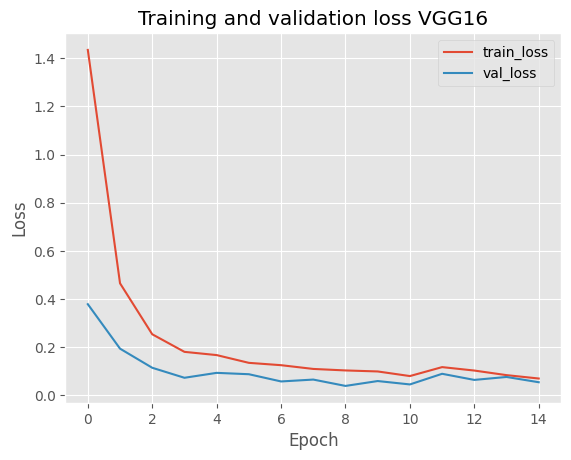

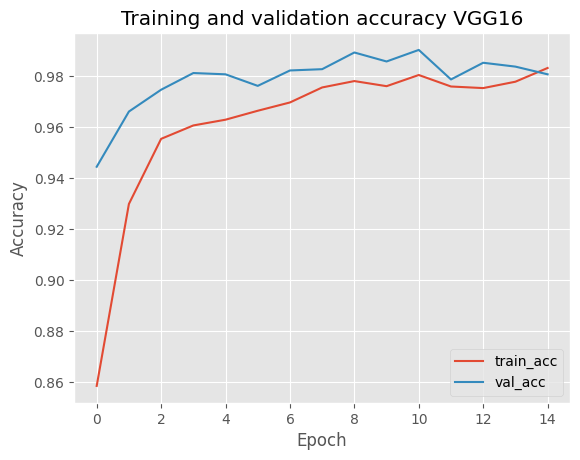

In [ ]:
N = np.arange(0, 15)

plt.style.use("ggplot")
plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.title("Training and validation loss VGG16")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "vgg_losses.png"]))
plt.legend()

plt.figure()
plt.plot(N, hist.history["accuracy"], label="train_acc")
plt.plot(N, hist.history["val_accuracy"], label="val_acc")
plt.title("Training and validation accuracy VGG16")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "vgg_accuracy.png"]))
plt.legend()

plt.show()

              precision    recall  f1-score   support

        open      0.977     0.969     0.973       388
       short      0.967     0.987     0.977       301
    mousebit      0.964     0.957     0.960       393
        spur      0.997     0.954     0.975       325
      copper      0.993     0.986     0.990       294
    pin-hole      0.946     0.997     0.971       300

    accuracy                          0.974      2001
   macro avg      0.974     0.975     0.974      2001
weighted avg      0.974     0.974     0.974      2001



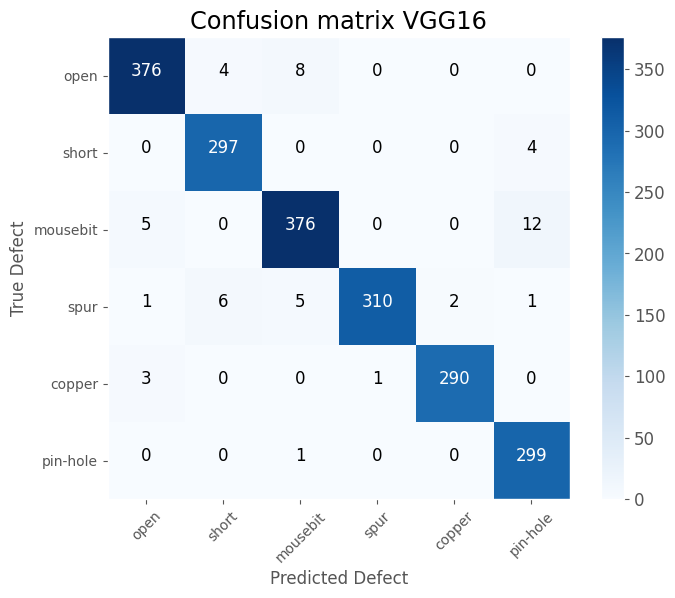

In [ ]:
import os
import sys
import itertools

# Suppressing the iteration updates
with open(os.devnull, 'w') as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull

    predictions = []
    for path in testGen.filepaths:
        image = cv2.imread(path)
        image = cv2.resize(image, (224, 224))
        image = np.expand_dims(image, axis=0)
        preds = model.predict(image)
        predictions.append(preds.argmax(axis=1))

    sys.stdout = old_stdout  # Restore stdout

predictions = np.concatenate(predictions)  # Flatten the list of predictions

print(classification_report(testGen.classes,
                            predictions,
                            target_names=testGen.class_indices,
                            digits=3))

plt.style.use("ggplot")
plt.grid(False)
plt.rcParams["figure.figsize"] = (8, 6)
font = {'size': 12}
plt.rc('font', **font)

cm = confusion_matrix(testGen.classes, predictions)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))

plt.xticks(tick_marks, testGen.class_indices, rotation=45)
plt.yticks(tick_marks, testGen.class_indices)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Defect')
plt.ylabel('True Defect')
plt.title('Confusion matrix VGG16')
plt.savefig('output/vgg16_confusion_matrix.png')
plt.show()


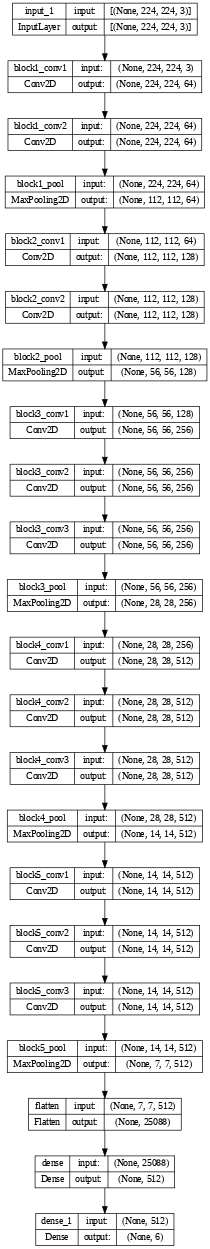

In [ ]:
from keras.models import load_model
from tensorflow.keras.utils import plot_model

# Load the saved model
model = load_model(os.path.sep.join([config.OUTPUT_PATH, "vgg.model"]))

# Visualize the architecture with reduced size
plot_model(model, to_file='vgg16_model_architecture.png', show_shapes=True, show_layer_names=True, dpi=50)